# QOSF Mentorship Program Screening Task 2

Implement a circuit that returns |01> and |10> with equal probability (50% for each).

Requirements :
The circuit should consist only of CNOTs, RXs and RYs. 
Start from all parameters in parametric gates being equal to 0 or randomly chosen. 	
You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:
How to make sure you produce state |01> + |10> and not |01> - |10> ?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)?)

## 1. Import modules

In [388]:
import cirq
import numpy as np
from numpy import pi
import random

##  2. Initialize two quibits q0 and q1 in both |0> state

In [347]:
q0,q1=[cirq.LineQubit(x) for x in range(2)]

## 3. Create a circuit that consist only of RX, RY and CNOT
We can create a circuit in which we operates Ry on q0 and Rx on q1 and then operate CNOT to them.
The parameters for RX and RY are thetaX and thetaY.
Now our problem is reduced to find the thetaX and thetaY for the intended output of the circuit. 

In [480]:
#In this function, we measure the output of the circuit 
#(Let's include the measurement for now. We can get rid of the measurement later)
def createCircuit(thetaX,thetaY):
    circ=cirq.Circuit()
    circ.append([cirq.ry(thetaY)(q0),cirq.rx(thetaX)(q1),cirq.CNOT(q0,q1),cirq.measure(q0),cirq.measure(q1)])
    return circ

This is what the circuit look like (with measurement operation on the output) :

In [481]:
#Example: thetaX=thetaY=0
print(createCircuit(0,0))

0: ───Ry(0.0π)───@───M───
                 │
1: ───Rx(0.0π)───X───M───


## 4. Simulation and evaluation of the circuit

### 4.1 Run simulation with cirq simulator with noise

In [490]:
def simulationResults(circ,repetitions=10000):
    return cirq.Simulator().run(circ,repetitions=repetitions).data 

An example of the results of simulation for 100 repetitions with thetaX=thetaY=2:

In [673]:
circ0=createCircuit(2,2)
results=simulationResults(circ0,repetitions=100)

In [674]:
results

,0,1
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
95,0,1
96,1,0
97,1,1
98,0,0


### 4.2 Cost function
In order to evaulate the circuit, we can define a cost function to calculate the different between the output state (before the measurement)and the |01> + |10> state.
In |01> + |10> state, both |01> and |10>) have a probability of 0.5 to be measured.
So we can define the cost function as:
abs(prob(|01>)-0.5)+abs(prob(|10>)-0.5)

In [494]:
#Given a set of measurement results, return the cost of the circuit
def cost(results):
    repetitions=len(results)
    state01_count=len(results[(results["0"]==0) & (results["1"]==1)]) #counting the number of |01> results
    state10_count=len(results[(results["0"]==1) & (results["1"]==0)]) #counting the number of |10> results
    #return the sum of the different of the probabilities of the two states
    return np.abs(state01_count/repetitions-0.5)+np.abs(state10_count/repetitions-0.5)

In [495]:
cost(results)

0.26

## 5. Optimization

### 5.1 Calculate the gradient of the cost function
To run gradient descent, we first need to calculate the partial derivatives of the cost function with respect to thetaX and thetaY for a certain stepsize.

In [497]:
# Calculate the partial derivatives of the cost function with respect to thetaX and thetaY, for any given thetaX and thetaY.
def grad(thetaX,thetaY,stepsize=0.01,repetitions=10000):
    old_cost=cost(simulationResults(createCircuit(thetaX,thetaY),repetitions=repetitions))
    new_cost_x=cost(simulationResults(createCircuit(thetaX+stepsize,thetaY),repetitions=repetitions))
    new_cost_y=cost(simulationResults(createCircuit(thetaX,thetaY+stepsize),repetitions=repetitions))
    return (new_cost_x-old_cost)/stepsize,(new_cost_y-old_cost)/stepsize

In [612]:
grad(0.4,0.5,stepsize=0.01,repetitions=100)

(5.000000000000004, 6.000000000000005)

### 5.2 Running the optimization

We can minimize the cost function by using gradient descent.

In [632]:
#return the optimized thetaX and thetaY by using gradient descent to minimize the cost function
def optimization(learning_rate=0.05):
    #initial values for thetaX and thetaY
    thetaX=random.random()*2*pi
    thetaY=random.random()*2*pi
    iterations=0
    #calculate the cost
    current_cost=cost(simulationResults(createCircuit(thetaX,thetaY),repetitions=10000))
    print("------------------- Iteration: ",iterations,"-------------------")
    print("Cost:",current_cost,"\nthetaX:",thetaX," thetaY:",thetaY)
    while(current_cost>0.01):
        
        #use smaller learning rates as the cost gets smaller
        if current_cost<0.5:
            learning_rate=0.1
        if current_cost<0.1:
            learning_rate=0.02
        if current_cost<0.02:
            learning_rate=0.004
        iterations+=1
        #calculate the partial derivatives
        d_thetaX,d_thetaY=grad(thetaX,thetaY,stepsize=0.01,repetitions=10000)
        #update thetaX and thetaY
        thetaX=thetaX-d_thetaX*learning_rate
        thetaY=thetaY-d_thetaY*learning_rate
        current_cost=cost(simulationResults(createCircuit(thetaX,thetaY),repetitions=10000))
        print("------------------- Iteration: ",iterations,"-------------------")
        print("Cost:",current_cost)
        print("thetaX:",thetaX," thetaY:",thetaY)
    return thetaX,thetaY

In [633]:
#runt the optimization to get thetaX and thetaY
thetaX,thetaY=optimization()

------------------- Iteration:  0 -------------------
Cost: 0.5742 
thetaX: 1.4263174255158708  thetaY: 1.9919961128761143
------------------- Iteration:  1 -------------------
Cost: 0.5419
thetaX: 1.4683174255158713  thetaY: 1.9969961128761144
------------------- Iteration:  2 -------------------
Cost: 0.5581
thetaX: 1.451317425515872  thetaY: 1.970996112876115
------------------- Iteration:  3 -------------------
Cost: 0.5429999999999999
thetaX: 1.4858174255158727  thetaY: 2.001496112876115
------------------- Iteration:  4 -------------------
Cost: 0.5287
thetaX: 1.5143174255158725  thetaY: 2.0084961128761147
------------------- Iteration:  5 -------------------
Cost: 0.5289
thetaX: 1.5068174255158722  thetaY: 1.9424961128761142
------------------- Iteration:  6 -------------------
Cost: 0.5052
thetaX: 1.5703174255158718  thetaY: 2.011496112876114
------------------- Iteration:  7 -------------------
Cost: 0.49039999999999995
thetaX: 1.6113174255158718  thetaY: 1.9834961128761137
--

### 6. Results and discussions
#### 6.1 After the optimization, we get the thetaX and thetaY as follows:

In [634]:
print(thetaX,thetaY)

3.2722774255158704 1.5711361128761103


 #### we get:
 
 thetaX = 3.2722774255158704 $\approx$ pi
 
 thetaY= 1.5711361128761103 $\approx$ pi/2

#### Compare the results for different numbers of measurements: 1, 10, 100, 1000.

In [665]:
circ_final=createCircuit(3.2722774255158704,1.5711361128761103) # using the values we get for thetaX and thetaY

In [666]:
print(circ_final)

0: ───Ry(0.5π)─────@───M───
                   │
1: ───Rx(1.042π)───X───M───


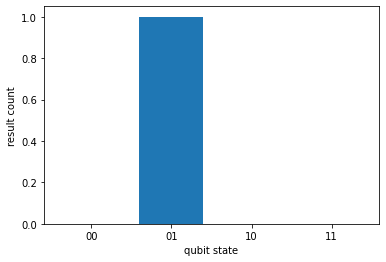

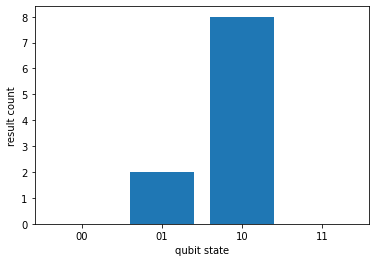

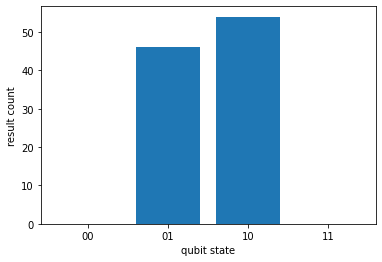

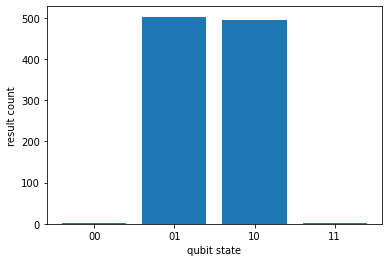

array([  1., 503., 495.,   1.])

In [670]:
#print the histogram for different numbers of measurements: 1, 10, 100, 1000.
cirq.plot_state_histogram(cirq.Simulator().run(circ_final,repetitions=1))
cirq.plot_state_histogram(cirq.Simulator().run(circ_final,repetitions=10))
cirq.plot_state_histogram(cirq.Simulator().run(circ_final,repetitions=100))
cirq.plot_state_histogram(cirq.Simulator().run(circ_final,repetitions=1000))

Counting results for 10000 measurements

In [672]:
simulationResults(createCircuit(3.2722774255158704,1.5711361128761103),10000).groupby(["0","1"]).size().reset_index(name="Count")

,0,1,Count
0,0,0,29
1,0,1,4952
2,1,0,4986
3,1,1,33


### 6.2 bonus discussion
#### Depending on the initial value of the thetaX and thetaY and the iterations, the circuit we get may return either |01> + |10> or |01> - |10> 
#### We can check which one it is by doing a simulation without measurement and noise.

In [675]:
def createCircuitNoMeasurement(thetaX,thetaY):
    circ=cirq.Circuit()
    circ.append([cirq.ry(thetaY)(q0),cirq.rx(thetaX)(q1),cirq.CNOT(q0,q1)])
    return circ

In [680]:
# for checking porpuse, let's use pi instead of 3.2722774255158704 and pi/2 instead of 1.5711361128761103 to filter out other states
circNoMeasurement=createCircuitNoMeasurement(pi ,pi/2)
print(circNoMeasurement)
cirq.Simulator().simulate(circNoMeasurement).dirac_notation()

0: ───Ry(0.5π)───@───
                 │
1: ───Rx(π)──────X───


'-0.71j|01⟩ - 0.71j|10⟩'

#### As the coefficients of |01> and |10> state are the same, we confirm that the above circuit returns |01> + |10>,  not |01> - |10>.

#### In some other optimizations, we may get thetaX=pi and thetaY = 3*pi/2 instead, that correspond to  |01> - |10>:

In [681]:
circNoMeasurement=createCircuitNoMeasurement(pi ,pi*3/2)
print(circNoMeasurement)
cirq.Simulator().simulate(circNoMeasurement).dirac_notation()

0: ───Ry(1.5π)───@───
                 │
1: ───Rx(π)──────X───


'0.71j|01⟩ - 0.71j|10⟩'